# Домашнее задание - линейная регрессия

### Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv 


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж 
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

Обработайте пропущенные значения и примените написанные функции onehot_encode() и minmax_scale().

**Подсказка**: маску для категориальных признаков можно сделать фильтром cat_features_mask = (df.dtypes == "object").values

### Импорт необходимых библиотек

In [1382]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import mean_squared_error
import optuna

import logging
%matplotlib inline

In [1383]:
logging.getLogger("optuna").setLevel(logging.WARNING) # логирование optuna

In [1384]:
sns.set_theme() # стилизация графиков

In [1385]:
def one_hot_encode(data, categories):
    
    indices_array = [categories.index(item) for item in data]
    num_classes = len(categories)
    one_hot_encoded = np.zeros((len(data), num_classes))
    one_hot_encoded[np.arange(len(data)), indices_array] = 1

    return one_hot_encoded

In [1386]:
def minmax_scale(x) :
    if x.shape[0] == 1 :
        return np.zeros((1, x.shape[1]))
    return (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))

### Первичный анализ данных, включая EDA

In [1387]:
data = pd.read_csv('data/travel.csv', sep=',')
data_prep = data.copy(deep=True)

data.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [1388]:
data.shape

(63326, 11)

In [1389]:
data.isna().sum()[data.isna().sum() > 0]

Gender    45107
dtype: int64

In [1390]:
numericalNotNa = data.dropna().select_dtypes(include=['float64', 'int64'])
numerical = data.select_dtypes(include=['float64', 'int64'])

Text(0.5, 0.95, 'Квантильные графики числовых переменных')

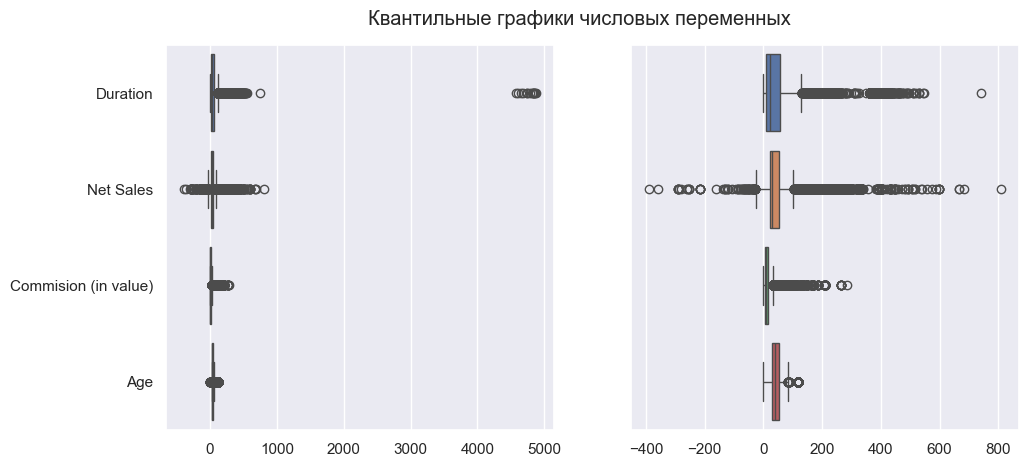

In [1391]:
fig = plt.figure(figsize=(11, 5))
(ax1, ax2) = fig.subplots(1, 2)

sns.boxplot(numerical, orient='y', ax=ax1)
sns.boxplot(numericalNotNa, orient='y', ax=ax2)
ax2.set_yticks([])
plt.suptitle('Квантильные графики числовых переменных', y=.95)

На графике мы можем увидеть явные выбросы в значениях переменной **Duration**, и некоторые отклонения у переменной **Age** (чуть выше 100 у некоторых обьектов)

### Очистка от выбросов, включая EDA

<Axes: xlabel='Age', ylabel='Count'>

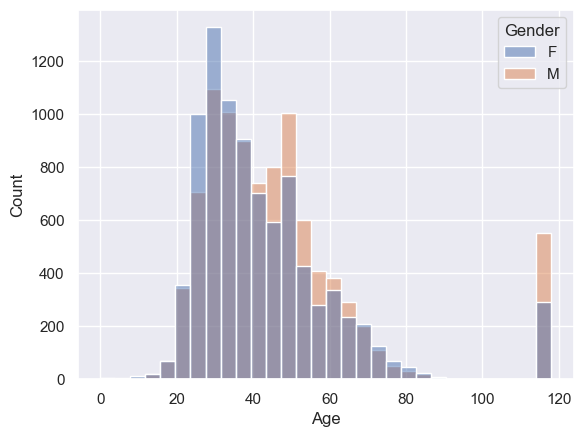

In [1392]:
sns.histplot(data, x='Age', hue='Gender', bins=30)

(группировка по полу нам понадобится позже для выявления связи между признаками и полом)

In [1393]:
data['Age'].quantile(np.linspace(0, 1, 101))

0.00      0.0
0.01     21.0
0.02     22.0
0.03     24.0
0.04     25.0
        ...  
0.96     65.0
0.97     69.0
0.98     75.0
0.99    118.0
1.00    118.0
Name: Age, Length: 101, dtype: float64

In [1394]:
display(((data['Age'] == 118)).sum())
display(((data['Age'] == 0)).sum())

np.int64(984)

np.int64(2)

**0** и **118** - явные выбросы **Age**

In [1395]:
data_prep = data_prep.loc[~data_prep['Age'].isin([0, 118])]

In [1396]:
pd.concat([data['Duration'], data_prep['Duration']], axis=1).quantile(np.linspace(0, 1, 11))

,Duration,Duration
0.0,-2.0,0.0
0.1,5.0,5.0
0.2,8.0,8.0
0.3,11.0,11.0
0.4,16.0,16.0
0.5,22.0,23.0
0.6,31.0,31.0
0.7,44.0,44.0
0.8,65.0,65.0
0.9,109.0,109.0


Воспользуемся ансамблевым методом **IsolationForest** (оптимальное и ускоренное решение в поиске выбросов)

In [1397]:
model = IsolationForest(random_state=42)

data_prep = data_prep[model.fit_predict(data_prep['Duration'].to_numpy().reshape(-1, 1)) != -1]

### Дальнейший анализ данных, изучение переменной **Gender**

Как мы можем заметить, есть единственная, переменная, что имеет пропущенные значения, причем через чур большое, и это **Gender**. Для непосредственной предобработки этого выборки нам может потребуется выявить зависимость между **Gender** и прочими переменными, что прийти к решению применить тот или иной способ замены **NA**-значений (мы можем вообще их отбросить)

In [1398]:
numericalAfter = data_prep.select_dtypes(include=['float64', 'int64'])

Text(0.5, 0.95, 'Графики корреляций между numerical-переменными и Gender')

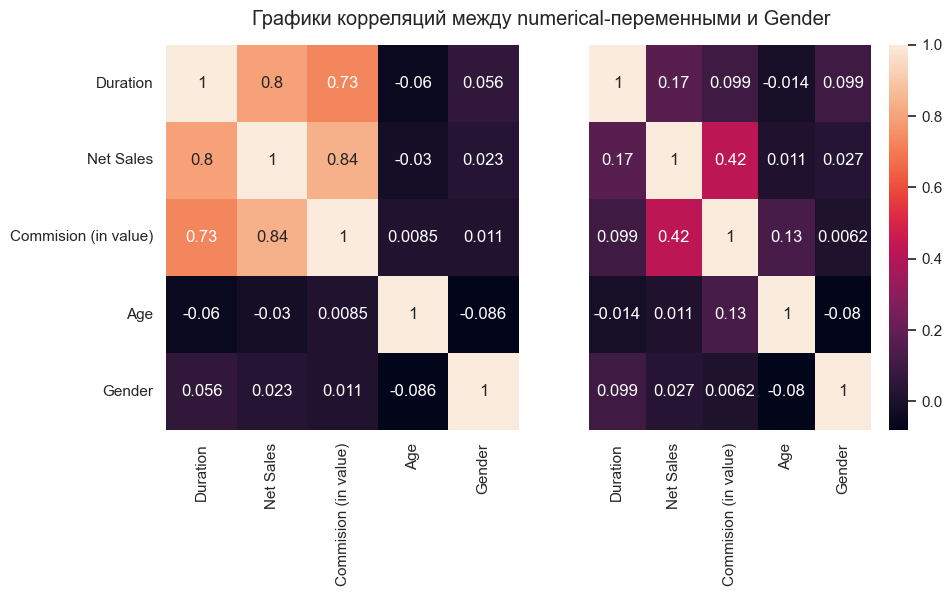

In [1399]:
fig = plt.figure(figsize=(10, 5))
(ax1, ax2) = fig.subplots(1, 2)

sns.heatmap(pd.concat([
    numericalNotNa, 
    data.dropna()['Gender'].map({'F' : 1, 'M' : 0})], axis=1).corr(), annot=True, ax=ax1, cbar=False)

sns.heatmap(pd.concat([
    numericalAfter.dropna(), 
    data_prep.dropna()['Gender'].map({'F' : 1, 'M' : 0})], axis=1).corr(), annot=True, ax=ax2)
ax2.set_yticks([])
plt.suptitle('Графики корреляций между numerical-переменными и Gender', y=0.95)

Text(0.5, 0.98, 'Количество объектов по полу')

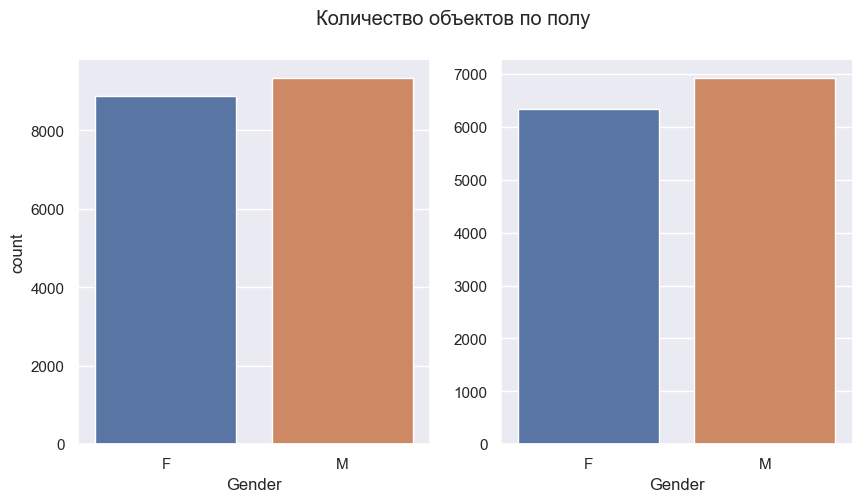

In [1400]:
fig = plt.figure(figsize=(10, 5))
(ax1, ax2) = fig.subplots(1, 2)

sns.countplot(data, x='Gender', hue='Gender', ax=ax1, legend=False)
sns.countplot(data_prep, x='Gender', hue='Gender', ax=ax2, legend=False)
ax2.set_ylabel('')
plt.suptitle('Количество объектов по полу')

In [1401]:
stat, p_value = stats.mannwhitneyu(data_prep['Age'][data_prep['Gender'] == 'F'], data_prep['Age'][data_prep['Gender'] == 'M'])

print('Статистика и p-value :', stat, np.round(p_value, 3))

Статистика и p-value : 19512786.0 0.0


<Axes: ylabel='Net Sales'>

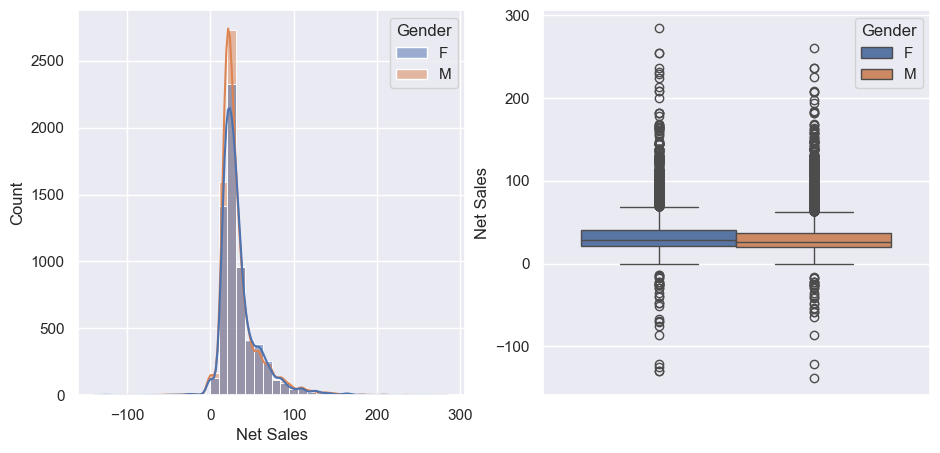

In [1402]:
fig = plt.figure(figsize=(11, 5))
(ax1, ax2) = fig.subplots(1, 2)

sns.histplot(data_prep, x='Net Sales', hue='Gender', bins=40, kde=True, ax=ax1)
sns.boxplot(data_prep, y='Net Sales', hue='Gender', ax=ax2)

In [1403]:
data_prep['Net Sales'].groupby(data_prep['Gender']).agg(['mean', 'std', 'min', 'max'])

,mean,std,min,max
Gender,,,,
F,34.667555,25.380687,-130.0,285.0
M,33.306479,24.471559,-138.0,260.0


In [1404]:
stat, p_value = stats.ttest_ind(
    data['Net Sales'][data['Gender'] == 'F'], 
    data['Net Sales'][data['Gender'] == 'M'])

print('Статистика и p-value :', stat, np.round(p_value, 3)) 

Статистика и p-value : 3.0672956453158933 0.002


In [1405]:
stat, p_value = stats.ttest_ind(
    data_prep['Net Sales'][data_prep['Gender'] == 'F'], 
    data_prep['Net Sales'][data_prep['Gender'] == 'M'])

print('Статистика и p-value :', stat, np.round(p_value, 3)) 

Статистика и p-value : 3.1436077165413723 0.002


Text(0.5, 0.95, 'Распределение Duration по Gender')

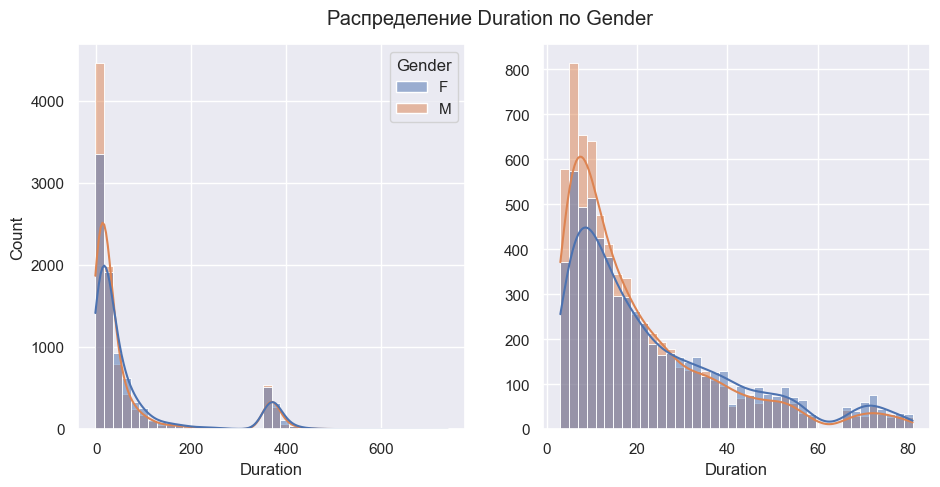

In [1406]:
fig = plt.figure(figsize=(11, 5))
(ax1, ax2) = fig.subplots(1, 2)

sns.histplot(data, x='Duration', hue='Gender', bins=40, kde=True, ax=ax1)
sns.histplot(data_prep, x='Duration', hue='Gender', bins=40, kde=True, ax=ax2, legend=False)
ax2.set_ylabel('')
plt.suptitle('Распределение Duration по Gender', y=.95)

In [1407]:
stat, p_value = stats.ttest_ind(
    data_prep['Duration'][data_prep['Gender'] == 'F'], 
    data_prep['Duration'][data_prep['Gender'] == 'M'])

print('Статистика и p-value :', stat, np.round(p_value, 3))

Статистика и p-value : 11.48482738434066 0.0


In [1408]:
for col in numerical.columns :
    stat, p_value = stats.mannwhitneyu(data[col], data_prep[col])

    print(f'Статистики  {stat}; P-value {np.round(p_value, 3)}')

Статистики  1761027618.5; P-value 0.0
Статистики  1613563885.0; P-value 0.0
Статистики  1599438999.5; P-value 0.0
Статистики  1577293850.0; P-value 0.0


In [1409]:
cat = data.select_dtypes(include=['object']).drop(columns='Gender')

In [1410]:
cat.nunique(axis=0)

Agency                   16
Agency Type               2
Distribution Channel      2
Product Name             26
Claim                     2
Destination             149
dtype: int64

In [1411]:
for col in cat.columns :
    
    contingency_table = pd.crosstab(data['Gender'], data[col])
    stat, p_value, _, _ = stats.chi2_contingency(contingency_table)

    contingency_table = pd.crosstab(data_prep['Gender'], data_prep[col])
    stat2, p_value2, _, _ = stats.chi2_contingency(contingency_table)

    print(f'Статистики  {stat}, {stat2}; P-value {np.round(p_value, 3)}, {np.round(p_value2, 3)}')

Статистики  650.7765742718424, 516.3739093856161; P-value 0.0, 0.0
Статистики  89.40089414727711, 68.22523483605134; P-value 0.0, 0.0
Статистики  100.78678822809714, 61.04347861624039; P-value 0.0, 0.0
Статистики  695.399231457945, 530.1746591099806; P-value 0.0, 0.0
Статистики  7.650771855929824, 8.859499365380724; P-value 0.006, 0.003
Статистики  695.3872836856849, 543.2303771080245; P-value 0.0, 0.0


- Исходя из приведенных тестов, можно наблюдать отсутствие критических различий между связью переменн и **Gender** *до* и *после* очистки от выбросов датасета
- Исходя из приведенных ниже результатов **EDA**, могу сказать о имеющейся связи между **Gender** и остальными переменными датасаета

### Предсказание оптимального **Gender**

#### Предобрабатываем данные

In [1412]:
data_prep.shape

(49005, 11)

In [1413]:
data_prep[data_prep['Gender'].notna()].shape[0]

13267

##### Для всех числовых величин, можно воспользоваться **minmax_scale** :

In [1414]:
data_prep[numericalAfter.columns] = minmax_scale(
    data_prep[numericalAfter.columns].to_numpy())

##### Кодировка категориальных данных будет осуществляться следующим образом :

- Если количество уникальных значений в категориальной колонке **равно 2**, будет применён метод **one-hot encoding**, так как он эффективно справляется с бинарными признаками, не добавляя избыточной информации.

- Если количество уникальных значений **больше 2**, будет применён метод **target encoding** (целевой кодировки). Этот подход позволяет учитывать связь между категориальными признаками и целевой переменной, что особенно полезно для признаков с большим количеством уникальных значений.

In [1415]:
for col in cat.drop(columns='Claim').columns :
    if data_prep[col].nunique() == 2 :
        data_prep[col] = one_hot_encode(
            data_prep[col], 
            categories=data_prep[col].unique().tolist())[:, 0]
    else :
        encoder = TargetEncoder()
        data_prep[col] = encoder.fit_transform(data_prep[[col]], (data_prep['Claim'] == 'Yes').astype('int'))

##### Целевая переменная **Gender**

In [1416]:
data_prep['Gender'] = data_prep['Gender'].map({'F' : 1, 'M' : 0})

##### Обучение и предсказание

In [1417]:
features, target = data_prep.dropna().drop(columns=['Claim', 'Gender']), data_prep.dropna()['Gender']

features.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age'],
      dtype='object')

In [1418]:
(X_train, X_test, 
 Y_train, Y_test) = train_test_split(features, target, test_size=0.2, random_state=42)

**Random Forest Regressor** был взят по ниже приведенным причинам :
**Random Forest** — это модель, которая использует много деревьев решений и объединяет их результаты :
- Хорошо работает на больших данных (а у тебя 16.000 элементов).
- Не переобучается, потому что усредняет ответы.
- Может понять сложные зависимости в данных.

Почему **Optuna** :
**Optuna** помогает автоматически подбирать лучшие настройки для модели (например, сколько деревьев использовать) :
- Быстрее, чем делать всё вручную.
- Умно выбирает параметры, чтобы улучшить результат.
- Экономит время, потому что может работать сразу на нескольких процессах.

In [1419]:
def objective(trial) :

    n_estimators = trial.suggest_int('n_estimators', 75, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(Y_test, y_pred)
    return -mse 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Лучшие гиперпараметры", study.best_params)
print("Score", study.best_value)

Лучшие гиперпараметры {'n_estimators': 164, 'max_depth': 10, 'min_samples_split': 8}
Score -0.23398179196369495


In [1420]:
model = RandomForestRegressor(**study.best_params)

model.fit(features, target)

data_prep.loc[data_prep['Gender'].isna(), 'Gender'] = np.round(model.predict(data_prep.loc[data_prep['Gender'].isna()].drop(columns=['Gender', 'Claim'])))

### Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

In [1421]:
features, target = data_prep.drop(columns=['Claim']), (data_prep['Claim'] == 'Yes').astype('int')

In [1422]:
# разделение на test/train
(X_train, X_test, 
 Y_train, Y_test) = train_test_split(features, target, test_size=0.2, random_state=42)

Найдите аналитическое решение для обучающей выборки: обычное и регуляризацией l2. 

In [1423]:
X_train_with_inter = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test_with_inter = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

In [1424]:
# посчитайте аналитическое решение
a = .1
w = np.linalg.inv(X_train_with_inter.T @ X_train_with_inter + 1 * np.identity(X_train_with_inter.shape[1])) @ X_train_with_inter.T @ Y_train

In [1425]:
# посчитать аналитическое решение с регуляризацией
Y_pred = X_test_with_inter @ w

MSE = mean_squared_error(Y_test.round(), Y_pred.round())

MSE

0.013059891847770635

Постройте модель LinearRegression, примените к тестовой выборке и посчитайте MSE (можно использовать библиотеку sklearn)

In [1426]:
model = LinearRegression(fit_intercept=True)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [1427]:
# посчитайте MSE, предварительно округлив предсказанные ответы до целого
MSE = mean_squared_error(Y_test.round(), Y_pred.round())

MSE

0.013059891847770635

### Опробуем "радикальный метод" предобработки данных

Попробуем избавиться от всех пропущенных значений **Gender**

In [1437]:
data_prep = data.copy(deep=True)

In [1438]:
data_prep.dropna(inplace=True)
data_prep = data_prep.loc[~data_prep['Age'].isin([0, 118])]
model = IsolationForest(random_state=42)
data_prep = data_prep[model.fit_predict(data_prep['Duration'].to_numpy().reshape(-1, 1)) != -1]

data_prep[numericalAfter.columns] = minmax_scale(
    data_prep[numericalAfter.columns].to_numpy())
    

for col in cat.drop(columns='Claim').columns :
    if data_prep[col].nunique() == 2 :
        data_prep[col] = one_hot_encode(
            data_prep[col], 
            categories=data_prep[col].unique().tolist())[:, 0]
    else :
        encoder = TargetEncoder()
        data_prep[col] = encoder.fit_transform(data_prep[[col]], (data_prep['Claim'] == 'Yes').astype('int'))

data_prep['Gender'] = data_prep['Gender'].map({'F' : 1, 'M' : 0})

data_prep.shape

(12171, 11)

In [1439]:
features, target = data_prep.drop(columns=['Claim']), (data_prep['Claim'] == 'Yes').astype('int')

In [1440]:
(X_train, X_test, 
 Y_train, Y_test) = train_test_split(features, target, test_size=0.2, random_state=42)

In [1441]:
X_train_with_inter = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test_with_inter = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

In [1442]:
# посчитайте аналитическое решение
a = .1
w = np.linalg.inv(X_train_with_inter.T @ X_train_with_inter + 1 * np.identity(X_train_with_inter.shape[1])) @ X_train_with_inter.T @ Y_train

In [1443]:
Y_pred = X_test_with_inter @ w

MSE = mean_squared_error(Y_test.round(), Y_pred.round())

MSE

0.026283367556468172

In [1444]:
model = LinearRegression(fit_intercept=True)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [1445]:
MSE = mean_squared_error(Y_test.round(), Y_pred.round())

MSE

0.026283367556468172

Оценка модели ухудшилась вдвое, что свидетельстует о том, что предыдущий способ был оптимальнее

### Вывод (1 **балл***)

Напишите краткий вывод по заданию (достаточно пары предложений). Расскажите, какие способы предобработки данных вы выбрали и почему. Насколько хороша ваша модель?

Само задание - классический пример проведения некоторого анализа, EDA и непосредственного обучения и предсказания целевой переменны на основе построенной модели - очень круто. В предложенном датасете **travel.csv** были мной обнаружены выбросы нескольких переменн, в частности **Gender** : доля NA-значений была определенно высокой, для чего и потребовались методы предобработки, в том числе и окончательный **dropna** *(обьяснение и описание примененных алгоритмов и методов для решения проблемы вы могли найти ниже, спасибо за оценку и простите за недочеты в дублированном коде и т.п :>>)*